# Advanced Mesh Composition

We are going to build the surface of a cube, optionally with certain geometries mounted into the faces. On each face, we want to have the ability of specifying a certain cross section from a variety of available options. For the latter we are going to use the `sectionproperties` library, that has plenty of pre-defined shapes. For the different mesh operations and the composition of the overall watertight mesh, we are going to use `sigmaepsilon.mesh`.

Import everything all at once:

In [1]:
from sigmaepsilon.mesh import PolyData, PointData, grid, triangulate
from sigmaepsilon.mesh.space import StandardFrame, PointCloud
from sigmaepsilon.mesh.cells import Q4, T3
from sigmaepsilon.mesh.utils import centralize, center_of_points
from sigmaepsilon.math.linalg import linspace
from sigmaepsilon.mesh.utils.tri import get_points_inside_triangles
from sigmaepsilon.mesh.utils.topology import remap_topo

from sectionproperties.pre.library.steel_sections import circular_hollow_section as CHS
from sectionproperties.pre.library.steel_sections import (
    rectangular_hollow_section as RHS,
)
from sectionproperties.pre.library.steel_sections import i_section
from sectionproperties.pre.pre import Material
import numpy as np

Although being irrelevant for the purpose of the example, for some operations to be available in `sectionproperties`, we have to provide a suitable material. 

In [2]:
# this aould be any material that sectionproperties accepts
steel = Material(
    name="Steel",
    elastic_modulus=200e3,
    poissons_ratio=0.3,
    density=7.85e-6,
    yield_strength=250,
    color="grey",
)

Define the database for this example like this:

In [3]:
from linkeddeepdict import LinkedDeepDict

database = LinkedDeepDict(
    {
        "left": {
            "geom": CHS(d=100, t=10, n=64),
        },
        "right": {
            "geom": CHS(d=100, t=10, n=64),
        },
        "front": {
            "geom": RHS(d=100, b=100, t=10, r_out=0, n_r=0, material=steel),
        },
        "back": {
            "geom": RHS(d=100, b=100, t=10, r_out=0, n_r=0, material=steel),
        },
        "top": {
            "geom": i_section(
                d=170, b=110, t_f=7.8, t_w=5.8, r=8.9, n_r=16, material=steel
            ),
        },
    }
)

To access a face, do this:

sectionproperties.pre.geometry.Geometry
object at: 0x1ea78c8d190
Material: Steel


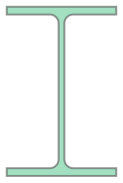

In [4]:
database["top", "geom"]

Define the size of the cube and the number of points along it's edges.

In [5]:
Lx = Ly = Lz = 220.0
points_per_edge = 25
mesh_size = Lx / (points_per_edge - 1)  # largest length of an edge

Create the geometry of the cube and local coordinate frames for each face. The maneouvers later in the notebook require some basic index management, which make the introduction of counters and different buffer objects inevitable.

In [6]:
points = []  # sink for points, it gets filled up in this block
frames = {}  # sink for face frames, it gets filled up in this block

nTotalPoints = 0  # node counter for contiguous node indices at the end

# corners
corner_coords = [
    [-Lx / 2, -Ly / 2, -Lz / 2],
    [Lx / 2, -Ly / 2, -Lz / 2],
    [Lx / 2, Ly / 2, -Lz / 2],
    [-Lx / 2, Ly / 2, -Lz / 2],
    [-Lx / 2, -Ly / 2, Lz / 2],
    [Lx / 2, -Ly / 2, Lz / 2],
    [Lx / 2, Ly / 2, Lz / 2],
    [-Lx / 2, Ly / 2, Lz / 2],
]
corner_coords = np.array(corner_coords)
points.append(corner_coords)
nTotalPoints += len(corner_coords)

# populate edges
nodes_of_edges = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 0],
    [4, 5],
    [5, 6],
    [6, 7],
    [7, 4],
    [0, 4],
    [1, 5],
    [2, 6],
    [3, 7],
]
edge_coords = []
N = points_per_edge + 2
for nodes in nodes_of_edges:
    p0 = corner_coords[nodes[0]]
    p1 = corner_coords[nodes[1]]
    edge_coords.append(linspace(p0, p1, N)[1:-1])
edge_coords = np.vstack(edge_coords)
points.append(edge_coords)
nTotalPoints += len(edge_coords)

# faces
corners_of_faces = {
    "front": [1, 2, 6, 5],
    "back": [0, 3, 7, 4],
    "left": [2, 3, 7, 6],
    "right": [0, 1, 5, 4],
    "bottom": [0, 1, 2, 3],
    "top": [4, 5, 6, 7],
}
edges_of_faces = {
    "front": [1, 5, 9, 10],
    "back": [3, 7, 8, 11],
    "right": [0, 9, 4, 8],
    "left": [2, 6, 10, 11],
    "bottom": [0, 1, 2, 3],
    "top": [4, 5, 6, 7],
}


def cof(id):
    """center of face"""
    return center_of_points(corner_coords[corners_of_faces[id]])


# face frames
frames = {}
GlobalFrame = StandardFrame(dim=3)

frames["front"] = GlobalFrame.orient_new().move(cof("front"))

frames["left"] = GlobalFrame.orient_new("Body", [0, 0, np.pi / 2], "XYZ").move(
    cof("left")
)

frames["back"] = GlobalFrame.orient_new("Body", [0, 0, np.pi], "XYZ").move(cof("back"))

frames["right"] = GlobalFrame.orient_new("Body", [0, 0, -np.pi / 2], "XYZ").move(
    cof("right")
)

frames["top"] = GlobalFrame.orient_new("Body", [0, -np.pi / 2, 0], "XYZ").move(
    cof("top")
)

frames["bottom"] = GlobalFrame.orient_new("Body", [0, np.pi / 2, 0], "XYZ").move(
    cof("bottom")
)

Create the seeds for the faces. We are going to be repeatedly repopulate these with the nodes
of the sections to create a surface triangulation.

In [7]:
coords_grid, topo_grid = grid(
    size=(Lx * 0.99, Ly * 0.99), shape=(N, N), eshape="Q4", centralize=True
)
pd = PointData(coords=coords_grid, frame=GlobalFrame)
cd = Q4(topo=topo_grid)
Grid = PolyData(pd, cd)
grid_centers = Grid.centers()[:, :2]

Repopulate the base seeds with section nodes for each face, do triangulations and save the resulting topology:

In [8]:
for face in frames:
    f_frame = frames[face]
    # collect points on corners and edges and their global indices
    # these indices are used later to remap the default topology
    # resulting from per-face triangulations
    f_coords_base = []
    f_inds_base = []
    _corner_inds = []
    for corner in corners_of_faces[face]:
        f_coords_base.append(corner_coords[corner])
        _corner_inds.append(corner)
    f_inds_base.append(np.array(_corner_inds, dtype=int))
    for edge in edges_of_faces[face]:
        inds = np.arange(points_per_edge) + edge * points_per_edge
        f_coords_base.append(edge_coords[inds])
        f_inds_base.append(inds + 8)
    f_coords_base = np.vstack(f_coords_base)
    sig_coords_base = np.zeros((f_coords_base.shape[0], 3)).astype(float)
    fixity_coords_base = np.zeros((f_coords_base.shape[0], 3)).astype(bool)

    # transform the coords (base coordinates) so far to face frame
    f_coords_base = PointCloud(f_coords_base, frame=GlobalFrame).show(f_frame)

    # global indices and number of corner and edge points
    f_inds_base = np.concatenate(f_inds_base)
    nBasePoints = len(f_inds_base)

    # build face
    if face in database:
        # 1) create the mesh of the section
        # 2) rule out points of the base grid that the section covers
        # 3) add corner and edge nodes and do a triangulation
        f_section = database[face]["geom"]
        f_section.create_mesh(mesh_sizes=[20.0])
        f_coords = centralize(np.array(f_section.mesh["vertices"]))

        n_section_nodes = f_coords.shape[0]
        f_topo = np.array(f_section.mesh["triangles"].tolist())[:, :3]
        f_inds = get_points_inside_triangles(f_coords, f_topo, grid_centers).astype(
            bool
        )
        f_coords = np.vstack([f_coords_base[:, 1:], f_coords, grid_centers[~f_inds]])
        f_coords, f_topo, _ = triangulate(points=f_coords)
    else:
        f_coords = np.vstack([f_coords_base[:, 1:], grid_centers])
        f_coords, f_topo, _ = triangulate(points=f_coords)

    # faces share some points, hence they must be consistent
    # in node numbering --> remap topology to match indices
    # of corner and edge nodes
    f_inds = np.zeros(len(f_coords), dtype=int)
    nNewPoints = len(f_coords) - nBasePoints
    f_inds[:nBasePoints] = f_inds_base
    f_inds[nBasePoints:] = np.arange(nNewPoints) + nTotalPoints
    nTotalPoints += nNewPoints
    f_topo = remap_topo(f_topo, f_inds)

    # transform to global and append new data to total collection
    f_coords_new = np.zeros((nNewPoints, 3))
    f_coords_new[:, 1:] = f_coords[nBasePoints:]
    f_coords = PointCloud(f_coords_new, frame=f_frame).show(GlobalFrame)
    points.append(f_coords)

    # add topology to face to total collection
    if face not in database:
        database[face] = {}
    database[face]["topo"] = f_topo

Summarize the results in a `PolyData` instance:

In [9]:
cubepoints = np.vstack(points)
pd = PointData(coords=cubepoints, frame=GlobalFrame)
cube = PolyData(pd)
for face in frames:
    cd = T3(topo=database[face]["topo"])
    cube[face] = PolyData(cd)

Plot a face or the entire model. We use `PyVista` in the background, which means you have a real powerhouse to visualize whatever you want, in multiple formats. This, combined with with `sigmaepsilon.mesh`, results in a very convenient user experience:

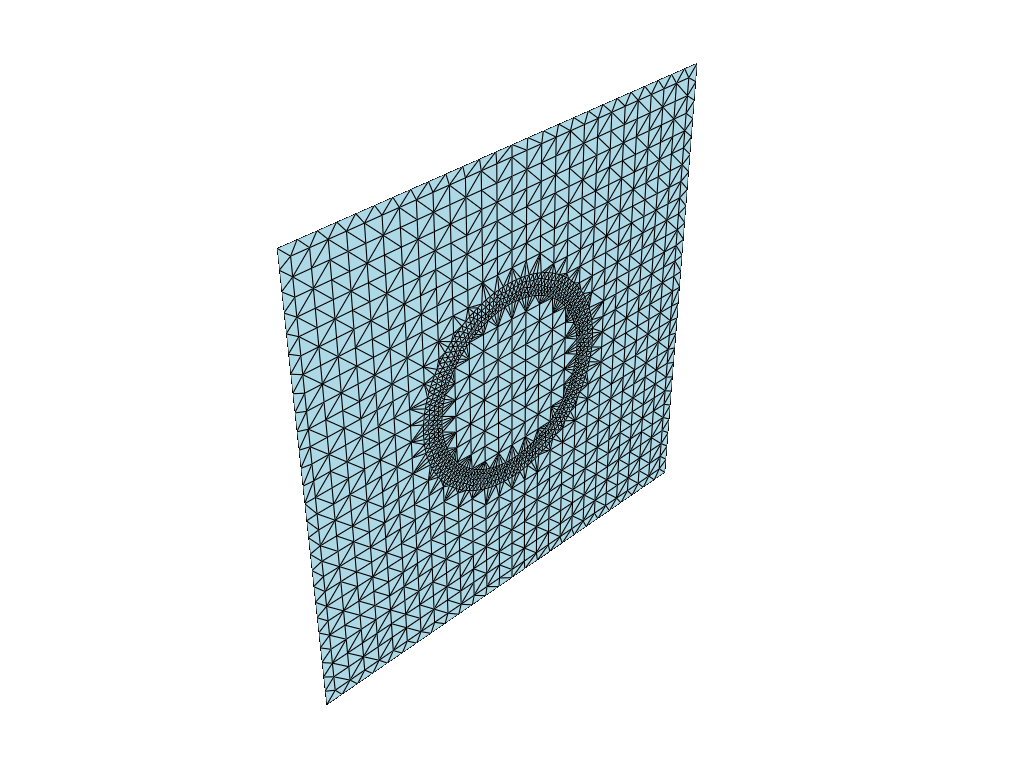

In [10]:
cube["left"].plot(notebook=True, jupyter_backend="static", theme="document")

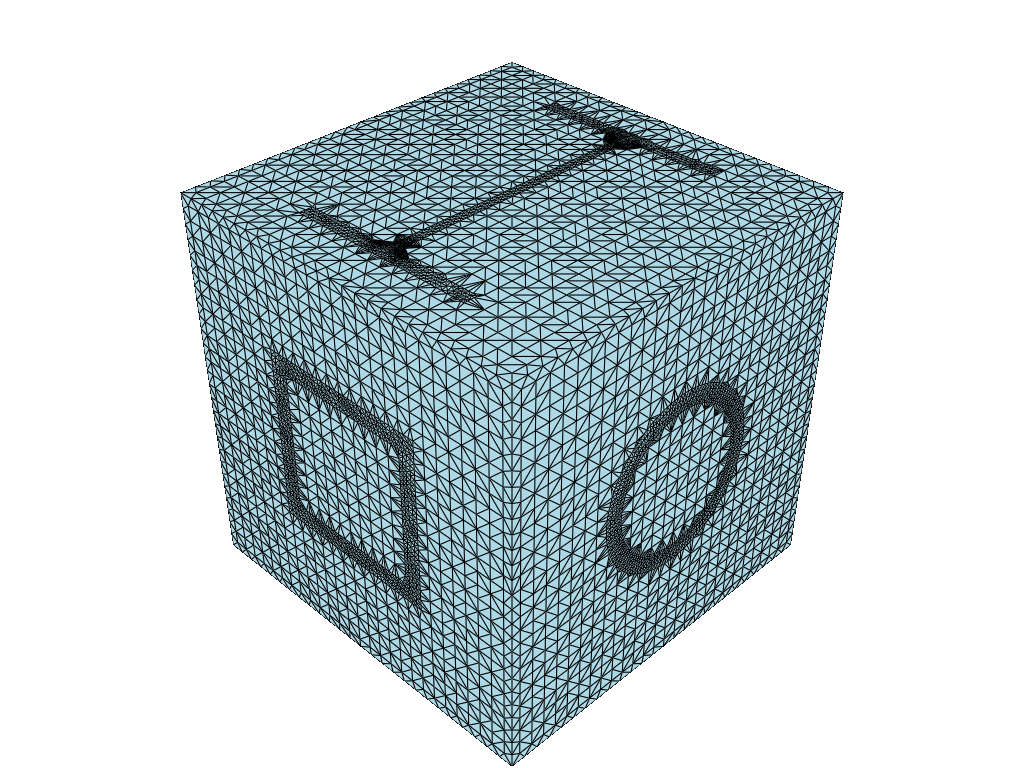

In [11]:
cube.plot(notebook=True, jupyter_backend="static", theme="document")